# Phase Circuit Simplification

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository.

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: C:\Users\Stefa\Documents\git\pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np
# import qiskit

<ipython-input-2-146a5b0addef>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Some utility code to display HTML elements and images/figures side-by-side:

In [3]:
from io import BytesIO
from typing import Union
from IPython.display import Image, HTML # type: ignore
def figure_to_image(fig: plt.Figure, fmt: str = "png") -> Image:
    """ Converts a Matplotlib figure to a PNG IPython Image. """
    buffer = BytesIO()
    fig.savefig(buffer, format=fmt)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    return Image(image_png, format=fmt, embed=True)
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

Importing the necessary PauliOpt classes:

In [4]:
from pauliopt.phase import PhaseCircuit, PhaseGadget, Z, X
from pauliopt.utils import pi, Angle
from pauliopt.topologies import Topology

A modified version of `PhaseCircuit.simplified`, displaying intermediate steps:

In [5]:
from typing import Dict, FrozenSet, List, Literal, Tuple
def display_step(num_qubits, pi_gates, groups):
    # Create the new list of gadgets
    new_gadgets: List[PhaseGadget] = []
    for q in range(num_qubits):
        if pi_gates["Z"][q]%2 == 1:
            # Single-qubit pi Z gate
            new_gadgets.append(PhaseGadget("Z", pi, {q}))
    for q in range(num_qubits):
        if pi_gates["X"][q]%2 == 1:
            # Single-qubit pi X gate
            new_gadgets.append(PhaseGadget("X", pi, {q}))
    for basis, angles in groups:
        for qubits, angle in angles.items():
            angle = angle % (2*pi)
            if angle != 0: # skip zero angle gadgets
                new_gadgets.append(PhaseGadget(basis, angle, qubits))
    display(PhaseCircuit(num_qubits, new_gadgets))
def display_simplification(circ: PhaseCircuit):
    num_qubits = circ.num_qubits
    gadgets = [g for g in circ.gadgets if not g.angle.is_zero]
    # Display original circuit
    print("Original circuit:")
    display(circ)
    # Groups of gadgets of the same basis, fused together where possible
    GadgetGroup = Tuple[Literal["Z", "X"], Dict[FrozenSet[int], Angle]]
    groups: List[GadgetGroup] = [("Z", {})]
    # The pi gates will be collected separately here
    pi_gates = {
        "Z": [0 for _ in range(num_qubits)],
        "X": [0 for _ in range(num_qubits)]
    }
    print("\nIn the first phase of the algorithm, we progressively "
          "grow groups of gadgets of the same colour, fusing where possible.")
    print("We start with an empty group for the Z basis.\n\n")
    step = 0
    # Perform the grouping and fusion
    for g in gadgets:
        step += 1
        basis, angles = groups[-1]
        g_basis = g.basis
        g_qubits = g.qubits
        g_angle = g.angle
        # Add the gadget to the current group, or create a new group.
        if g_basis == basis:
            # Add gadget to current group (fuse if possible)
            if g_qubits in angles:
                angles[g_qubits] += g_angle
                print(f"After Step {step}, fused gadget into current group:")
                display_step(num_qubits, pi_gates, groups)
            else:
                angles[g_qubits] = g_angle
                print(f"After Step {step}, added gadget to current group:")
                display_step(num_qubits, pi_gates, groups)
        else:
            # Create a new group (basis has changed)
            groups.append((g_basis, {g_qubits: g_angle}))
            print(f"After Step {step}, created new gadget group:")
            display_step(num_qubits, pi_gates, groups)
    print("\nIn the second phase of the algorithm, we commute gadgets to the left.")
    print("We fuse gadgets into new groups if possible and apply pi-gadget simplification.\n")
    # Perform all commutations, fusions and pi gadget simplifications
    for i, (basis, angles) in enumerate(groups): # pylint: disable = too-many-nested-blocks
        # Try commuting all gadgets to the left as much as possible
        for qubits, angle in angles.items():
            if angle == 0:
                # Skip zeroed gadgets
                continue
            step += 1
            # Try to commute the gadget to the left as much as possible
            j = i # j is the current group to which the gadget has been commuted
            obstacle_found = False # this records whether we found an obstacle
            while not obstacle_found and j >= 2:
                _, angles_commute = groups[j-1] # angles to commute through
                for qubits_commute, angle_commute in angles_commute.items():
                    if angle_commute.is_zero:
                        # Zero angle gadget, not an obstable
                        continue
                    if len(qubits&qubits_commute) % 2 != 0:
                        # Odd number of shared legs, obstacle found
                        obstacle_found = True
                        break
                if not obstacle_found:
                    # Go to the next group of same basis down the list
                    j -= 2
            # Fuse the gadget into the group, and apply pi gate simplification
            pi_gadget = False
            if j < i:
                # We managed to perform some non-trivial commutation
                angles[qubits] = Angle.zero
                _, angles_fuse = groups[j]
                if qubits in angles_fuse:
                    # Fuse with existing gadget on same qubits and same basis
                    angles_fuse[qubits] += angle
                else:
                    angles_fuse[qubits] = angle
                    # Add gadget to group
                if angles_fuse[qubits].is_pi:
                    print(f"Middle of Step {step}, commutation performed, pi-gadget handling to follow:")
                    display_step(num_qubits, pi_gates, groups)
                    # This is a pi gadget, further simplification to be performed
                    angles_fuse[qubits] = Angle.zero # Remove gadget from this group
                    pi_gadget = True
                else:
                    print(f"After Step {step}, commutation performed, no pi-gadget handling:")
                    display_step(num_qubits, pi_gates, groups)
            elif angle.is_pi:
                print(f"Middle of Step {step}, no commutation performed, but pi-gadget handling to follow:")
                display_step(num_qubits, pi_gates, groups)
                # We didn't manage to commute the gadget, but it is a pi gadget
                angles[qubits] = Angle.zero # Remove gadget from this group
                pi_gadget = True
            else:
                print(f"After Step {step}, no commutation performed, no pi-gadget handling:")
                display_step(num_qubits, pi_gates, groups)
            if pi_gadget:
                # pi gadget
                for k in range(0, j)[::-2]:
                    # Commute through gadgets below of other basis, flipping sign if necessary
                    _, angles_k = groups[k]
                    for qubits_k in angles_k:
                        if len(qubits_k&qubits)%2 == 1:
                            # Odd number of legs in comon: flip sign
                            angles_k[qubits_k] *= -1
                for q in qubits:
                    # Break into single-qubit pi gates, recorded separately (at start of circ)
                    pi_gates[basis][q] += 1
                print(f"After Step {step}, pi-gadget handling performed:")
                display_step(num_qubits, pi_gates, groups)


## Phase Circuit Construction

The `PhaseCircuit` class has methods that can be used to add standard quantum gates to a phase circuit, implemented by phase gadgets.

Pauli X, Y and Z gates:

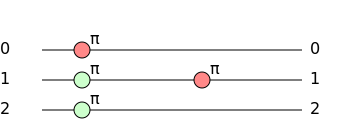

In [6]:
circ = PhaseCircuit(3)
circ.x(0)
circ.y(1)
circ.z(2)
circ.to_svg()

Hadamard, S and T gates:

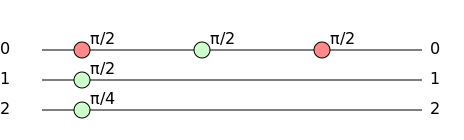

In [7]:
circ = PhaseCircuit(3)
circ.h(0)
circ.s(1)
circ.t(2)
circ.to_svg()

X, Y and Z rotation gates:

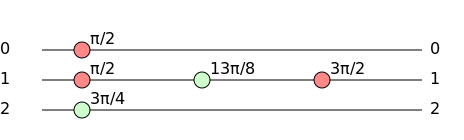

In [8]:
circ = PhaseCircuit(3)
circ.rx(0, pi/2)
circ.ry(1, 13*pi/8)
circ.rz(2, 3*pi/4)
circ.to_svg()

CX, CY and CZ gates:

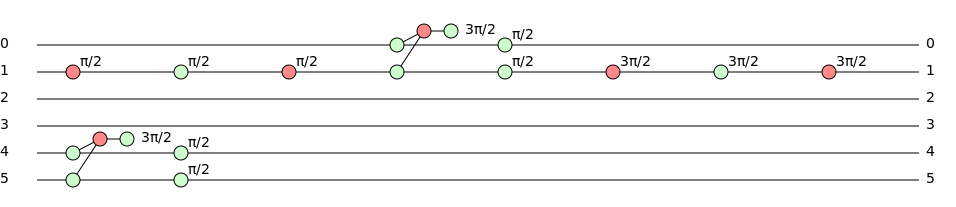

In [9]:
circ = PhaseCircuit(6)
circ.cx(0, 1)
# circ.cy(2, 3) # to be implemented
circ.cz(4, 5)
circ.to_svg(scale=0.9)

Controlled X, Y and Z rotation gates and controlled U1 gate:

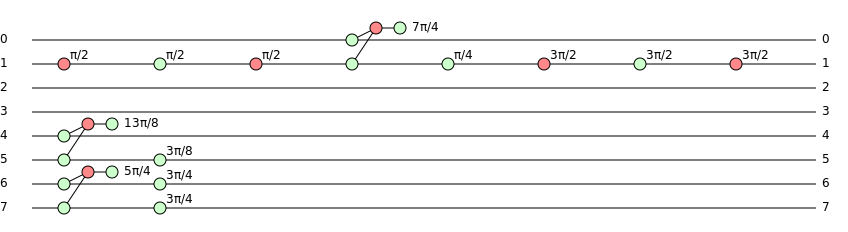

In [10]:
circ = PhaseCircuit(8)
circ.crx(0, 1, pi/2)
# circ.cry(2, 3, 13*pi/8) # to be implemented
circ.crz(4, 5, 3*pi/4)
circ.cu1(6, 7, 3*pi/4)
circ.to_svg(scale=0.8)

Gate application can be concatenated for convenience (see the [fluent interface pattern](https://en.wikipedia.org/wiki/Fluent_interface)).

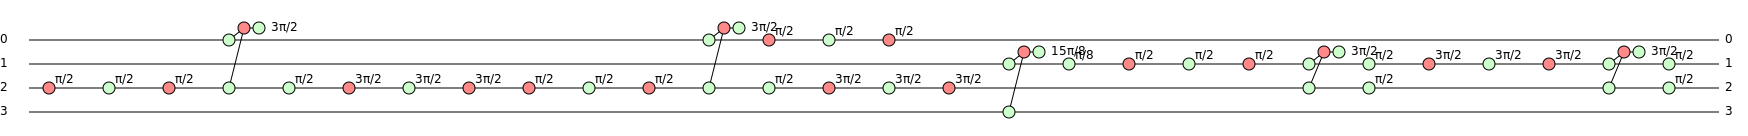

In [11]:
circ = PhaseCircuit(4)
circ.crx(0,2,pi).crx(0,2,pi).crz(3,1,pi/4).cx(2,1).cz(1,2).h(0)
circ.to_svg(vscale=0.8, hscale=0.5)

## Phase Circuit Simplification

The commutation and fusion rules for phase gadgets can be used to deterministically simplify phase circuits:

1. The gadgets are divided into contiguous blocks of same basis gadgets (alternating Z and X basis) and gadgets within the same group with the same legs are fused.
2. Proceeding left-to-right through the groups:

    1. each gadget in each group is commuted to the left as much as possible (commuting through gadgets with which it shares an even number of legs).
    2. Once the leftmost possible group is reached by the commutation process of Step 2, the gadget is added to/fused into the group.
    3. If the gadget just added/fused has an angle of $\pi$, it is broken into single-qubit $\pi$ gadgets for all its legs, which are commuted all the way to the beginning of the circuit. In this process, each single-qubit $\pi$ gadget flips the sign of the angle for every gadget of the other basis which it commutes through and which shares a leg with it.
    
At the end of this process, each qubit has at most a single-qubit $\pi$ gadget for each of the Z and X bases, at the beginning of the circuit. These $\pi$ gates are followed by contiguous groups of gadgets of the same basis, no two gadgets in each group sharing exactly the same legs, no gadget in any group that can be non-trivially commuted leftward.

A small example:

Original:


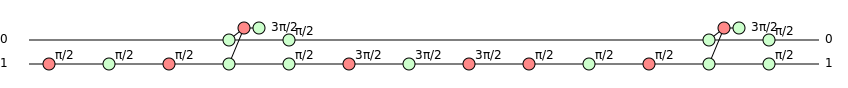


Simplified:


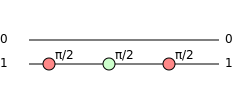

In [12]:
circ = PhaseCircuit(2)
circ.cx(0, 1).h(1).cz(0, 1)
print("Original:")
display(circ.to_svg(vscale=0.8, hscale=0.5))
print("\nSimplified:")
circ_simplified = circ.simplified()
display(circ_simplified.to_svg(vscale=0.8, hscale=0.5))

Another, longer example:

Original:


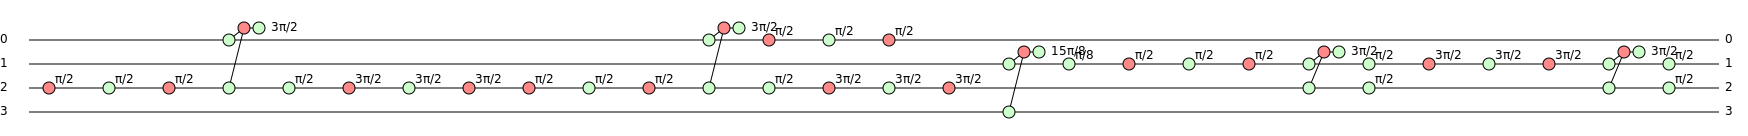



Simplified:


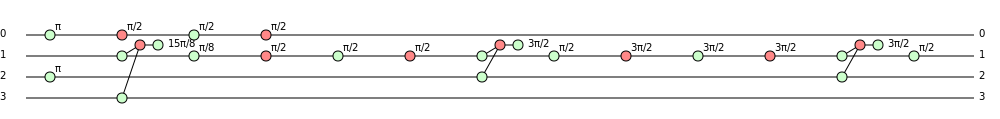

In [14]:
circ = PhaseCircuit(4)
circ.crx(0,2,pi).crx(0,2,pi).crz(3,1,pi/4).cx(2,1).cz(1,2).h(0)
print("Original:")
display(circ.to_svg(vscale=0.8, hscale=0.5))
print("\n\nSimplified:")
circ_simplified = circ.simplified()
display(circ_simplified.to_svg(vscale=0.7, hscale=0.6))

We take a look at the individual steps of the simplification procedure:

Original circuit:


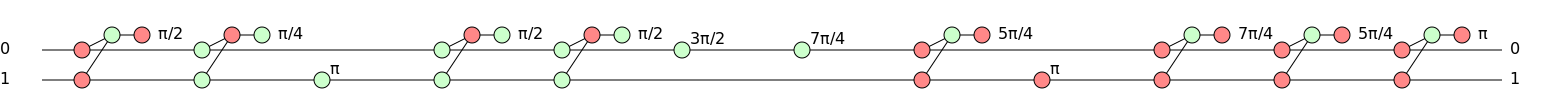


In the first phase of the algorithm, we progressively grow groups of gadgets of the same colour, fusing where possible.
We start with an empty group for the Z basis.


After Step 1, created new gadget group:


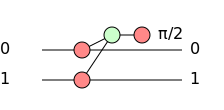

After Step 2, created new gadget group:


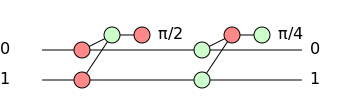

After Step 3, added gadget to current group:


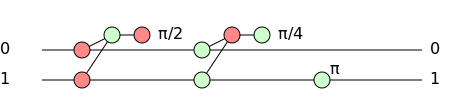

After Step 4, fused gadget into current group:


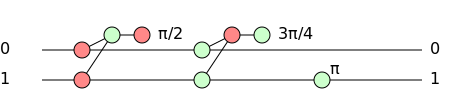

After Step 5, fused gadget into current group:


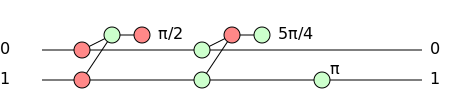

After Step 6, added gadget to current group:


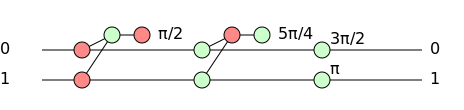

After Step 7, fused gadget into current group:


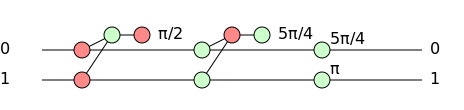

After Step 8, created new gadget group:


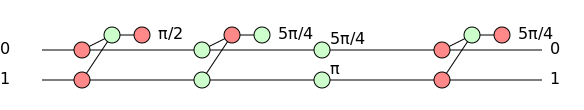

After Step 9, added gadget to current group:


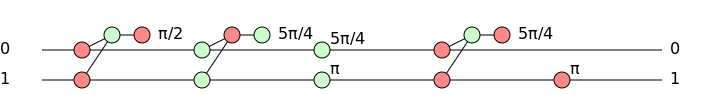

After Step 10, fused gadget into current group:


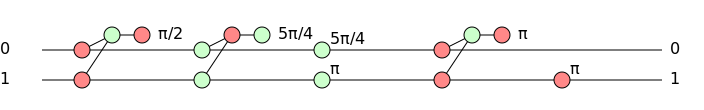

After Step 11, fused gadget into current group:


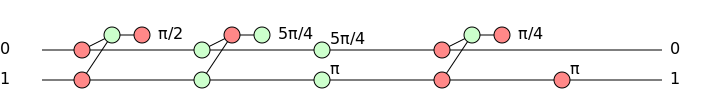

After Step 12, fused gadget into current group:


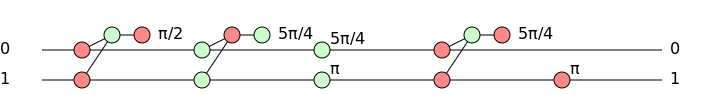


In the second phase of the algorithm, we commute gadgets to the left.
We fuse gadgets into new groups if possible and apply pi-gadget simplification.

After Step 13, no commutation performed, no pi-gadget handling:


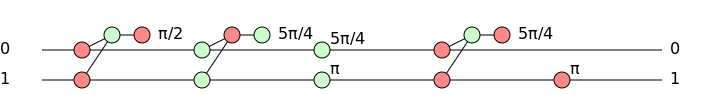

After Step 14, commutation performed, no pi-gadget handling:


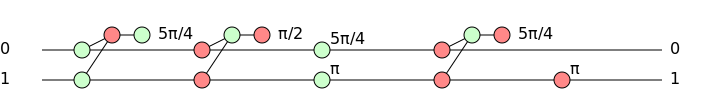

Middle of Step 15, no commutation performed, but pi-gadget handling to follow:


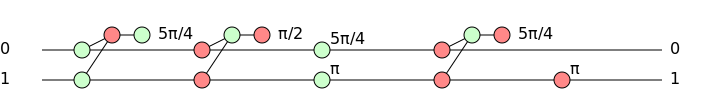

After Step 15, pi-gadget handling performed:


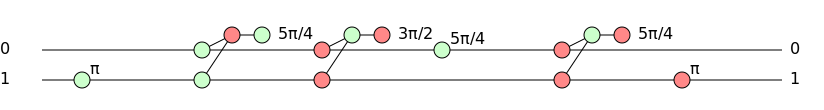

After Step 16, no commutation performed, no pi-gadget handling:


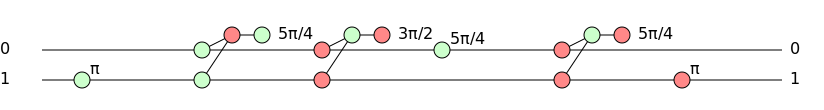

After Step 17, no commutation performed, no pi-gadget handling:


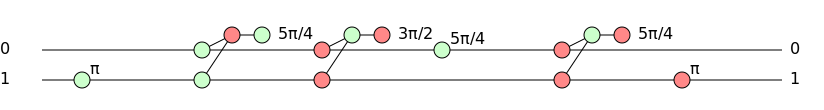

Middle of Step 18, commutation performed, pi-gadget handling to follow:


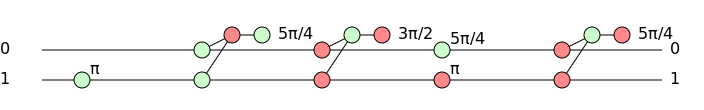

After Step 18, pi-gadget handling performed:


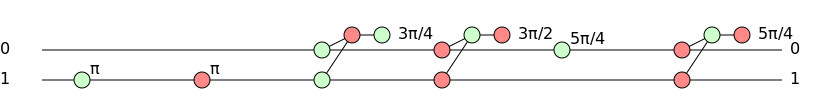

In [15]:
topology = Topology.line(2)
circuit = PhaseCircuit.random(topology.num_qubits, 12, min_legs=1, max_legs=2, rng_seed=6)
display_simplification(circuit)

## QASM circuit loading

Phase circuits can be loaded from QASM programs, using the static `PhaseCircuit.from_qasm` method.

The following is a QASM sample from the [QUEKO benchmarks](https://github.com/tbcdebug/QUEKO-benchmark): a 10-cycle circuit for the 16-qubit Rigetti Aspen-4 topology (specifically, `16QBT_10CYC_TFL_3` from the `BNTF` series).

In [16]:
qasm_code = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[16];
x q[0];
x q[2];
x q[10];
x q[9];
x q[7];
cx q[14], q[12];
cx q[13], q[6];
x q[0];
x q[7];
x q[11];
x q[4];
x q[5];
cx q[12], q[1];
cx q[6], q[10];
x q[7];
cx q[0], q[11];
cx q[12], q[1];
cx q[9], q[5];
cx q[2], q[8];
x q[10];
x q[9];
x q[4];
x q[8];
x q[3];
cx q[11], q[14];
cx q[15], q[2];
cx q[12], q[7];
cx q[13], q[0];
x q[11];
x q[7];
x q[3];
x q[12];
x q[14];
x q[8];
cx q[6], q[10];
cx q[13], q[0];
x q[11];
x q[8];
x q[1];
x q[14];
x q[13];
cx q[12], q[7];
cx q[3], q[5];
x q[9];
x q[10];
cx q[11], q[14];
cx q[12], q[1];
cx q[2], q[8];
x q[11];
x q[2];
x q[4];
x q[15];
x q[8];
x q[14];
cx q[13], q[6];
cx q[7], q[9];
cx q[12], q[1];
x q[11];
x q[7];
x q[9];
x q[1];
cx q[14], q[12];
cx q[13], q[6];
cx q[3], q[5];
cx q[8], q[4];
x q[11];
x q[12];
x q[0];
x q[10];
x q[14];
cx q[7], q[9];
cx q[3], q[5];
cx q[8], q[4];
"""

We create a topology matching the one for the 16-qubit Rigetti Aspen-4 device:

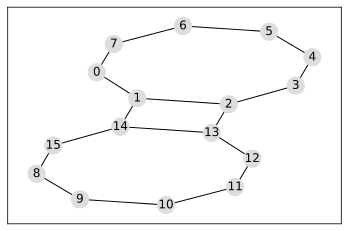

In [17]:
rigetti_16q_topology = Topology(16,
    [[i, (i+1)%8] for i in range(0,8)]
    +[[8+i, 8+(i+1)%8] for i in range(0,8)]
    +[[2, 13], [1, 14]]
)
rigetti_16q_topology.draw()

The QUEKO benchmarks come with an optimal mapping of logical-to-physical qubits for the given topology.

In [18]:
optimal_mapping = [1, 10, 5, 15, 7, 14, 8, 12, 6, 13, 9, 2, 11, 0, 3, 4]

We compare the original and simplified circuits. For the CX count, we use the optimal mapping from the QUEKO benchmarks

Original number of gadgets: 305
Original CX count: 118


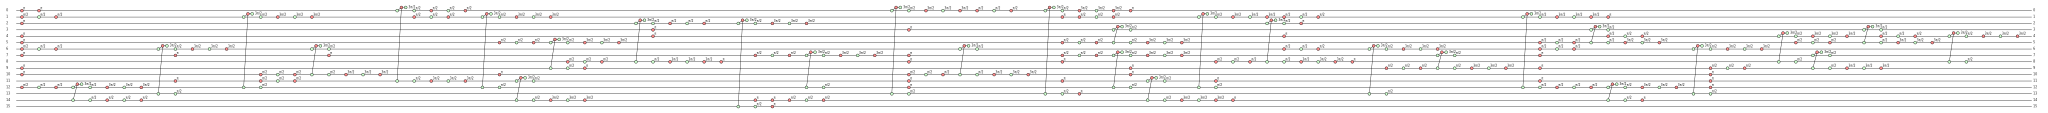



Simplified number of gadgets: 57 (change: -81.3%)
Simplified CX count: 26 (change: -78.0%)


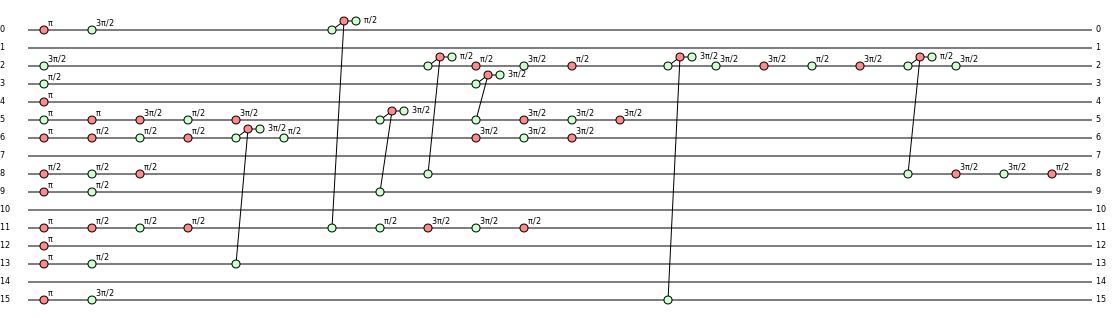

In [19]:
circuit = PhaseCircuit.from_qasm(qasm_code)
orig_len = len(circuit)
orig_count = circuit.cx_count(rigetti_16q_topology, mapping=optimal_mapping)
print(f"Original number of gadgets: {orig_len}")
print(f"Original CX count: {orig_count}")
display(circuit.to_svg(vscale=0.6, hscale=0.4))
print(); print()
circuit_simplified = circuit.simplified()
simpl_len = len(circuit_simplified)
simpl_count = circuit_simplified.cx_count(rigetti_16q_topology, mapping=optimal_mapping)
len_change = (simpl_len-orig_len)/orig_len
count_change = (simpl_count-orig_count)/orig_count
print(f"Simplified number of gadgets: {simpl_len} (change: {len_change:.1%})")
print(f"Simplified CX count: {simpl_count} (change: {count_change:.1%})")
display(circuit_simplified.to_svg(vscale=0.6, hscale=0.4))